In [3]:
# Step 0: load the checkpoints (autoencoder, diffusion, and classifier models)
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from lsdm.models.diffusion.ddim import DDIMSampler
from omegaconf import OmegaConf
from lsdm.util import instantiate_from_config
import albumentations
from torchvision import transforms
from lsdm.data.general import DatasetWithClassifierAPIValidation
from lsdm.data.lidc import LIDCNoduleMalignancyClassifierBalancedValidation
from torch.utils.data import DataLoader

"""
Parameters:
"""
# TODO: create meta config file.
device = "cuda:0"
key_feature = "others"  # for new csv files, choose "others"
lsdm_config = "configs/latent-diffusion/lsdm-LIDC-IDRI.yaml"
classifier_config = "configs/classifier/classifier-malignancy.yaml"
classifier_ckpt = "/home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/classifier_mali/epoch119.ckpt"

def load_model_from_config(config, ckpt, device=device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=torch.device("cpu"))#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(torch.device(device))  # load on cuda:1
    model.eval()
    return model

def get_lsdm_model():
    config = OmegaConf.load(lsdm_config)  
    model = load_model_from_config(config, config.model.params.unet_config.params.ckpt_path)
    return model

# load LSDM model (autoencoder+diffusion):
lsdm_model = get_lsdm_model()
# load the sampler with classifier model:
sampler = DDIMSampler(lsdm_model,
                      classifier_guidance=key_feature,
                      classifier_config=classifier_config,
                      classifier_ckpt=classifier_ckpt,)

Loading model from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/lsdm_kl_128x128x3_512resolution/epoch122.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 375.88 M params.
Keeping EMAs of 690.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 128, 128) = 49152 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/autoencoder_kl_128x128x3_512resolution/epoch19.ckpt
Training LatentDiffusion as an unconditional model.
[LSDM classifier] Loading model from /home/zuxinrui/thesis-LSDM/nodule_malignancy/LSDM/logs/classifier_mali/epoch119.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 306.78 M params.
Keeping EMAs of 552.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 128, 128) = 49152 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/zuxin

forming training dataset label list...
training dataset label list formed.
dict_keys(['c_spade', 'mask', 'position', 'crop_size_half'])
['/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-1002-84.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0956-76.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0913-82.jpg', '/home/zuxinrui/Desktop/TUDelft/Datasets/LIDC/test/image/LIDC-IDRI-0924-149.jpg']


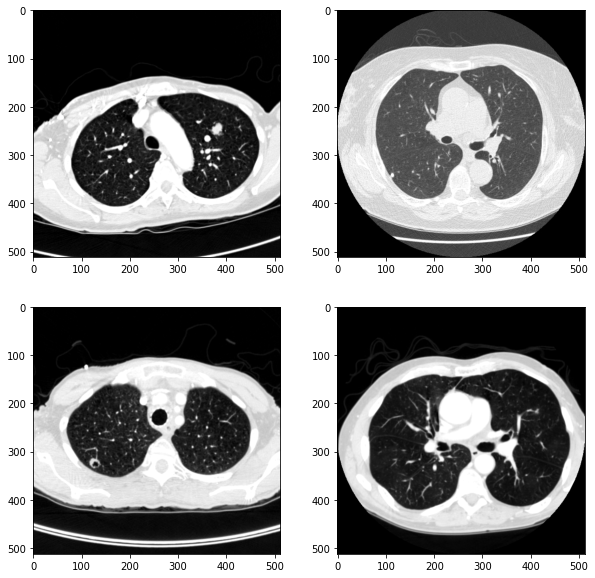

In [5]:
# STEP 0.1: plot the original figures:
"""
Parameters:
"""
bs = 4

dataset = LIDCNoduleMalignancyClassifierBalancedValidation(nodule_crop_size=64, 
                                                           training_set=False, 
                                                           maxpooling_pixels=4, 
                                                           masked_guidance=True,
                                                           return_original_label=True,
                                                           )
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
for i, batch in enumerate(dataloader):
    c_dict = {}
#     c_dict["image"] = [batch["image"]]
    c_dict["c_spade"] = [batch["label"].to("cuda")]
    c_dict["mask"] = batch["mask"]
    c_dict["position"] = batch["position"]
    c_dict["crop_size_half"] = batch["crop_size_half"]
    break
print(c_dict.keys())
print(batch["filename"])
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs // 2,2,i+1)
    ax.imshow(batch["original_image"][i,:,:], cmap="gray")

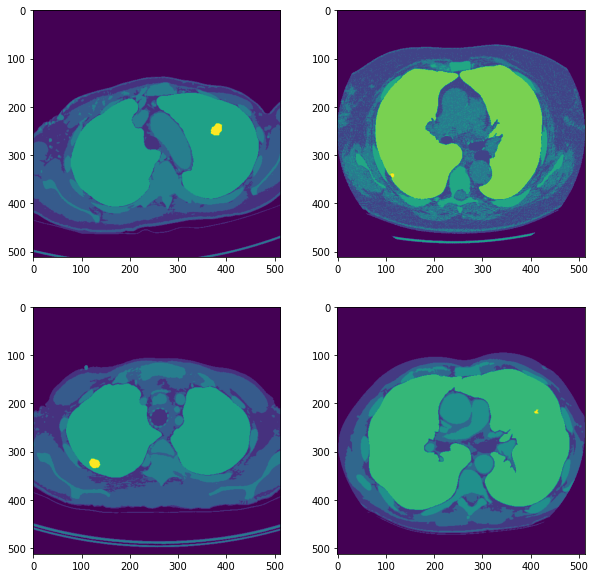

In [7]:
# STEP 0.2: plot the original semantic maps:
fig = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax = fig.add_subplot(bs // 2,2,i+1)
    ax.imshow(batch["original_label"][i,:,:])

DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 128, 128), eta 1.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


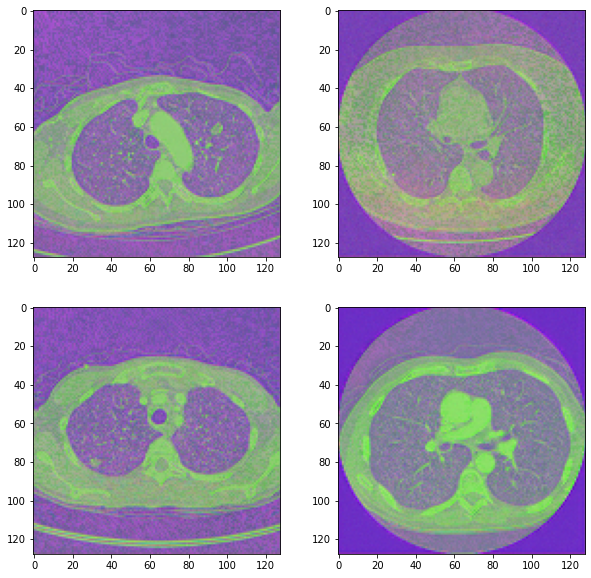

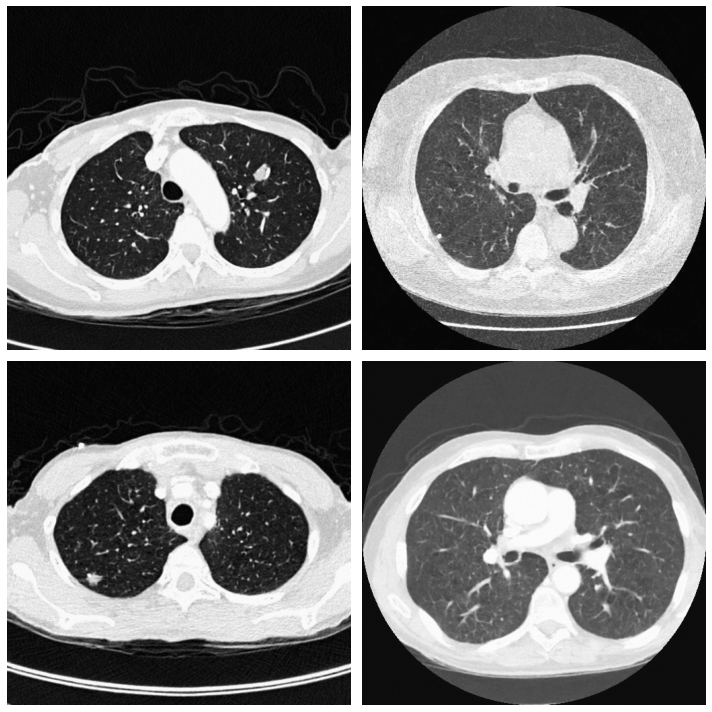

In [17]:
# STEP 1: generation:
"""
Parameters:
"""
sampling_steps = 20
class_label = 0  # {0,1}
guidance_scale = 1.

# generate latent:
samples_ddim, intermediates = sampler.sample_classifier_guidance(S=sampling_steps,
                                                                 conditioning=c_dict,
                                                                 class_label=class_label,
                                                                 batch_size=bs,
                                                                 shape=[3, 128, 128],
                                                                 verbose=False,
                                                                 unconditional_guidance_scale=3.0,
                                                                 eta=1.0,
                                                                 classifier_guidance_scale=guidance_scale,
                                                                 )
# normalize:
latent = (samples_ddim - torch.min(samples_ddim)) / (torch.max(samples_ddim) - torch.min(samples_ddim))
latent = torch.permute(latent, (0,2,3,1)).cpu().numpy()
latent = (latent * 255).astype(np.uint8)
fig1 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax1 = fig1.add_subplot(bs // 2,2,i+1)
    ax1.imshow(latent[i,:,:,:])

# generated images:
lsdm_model.eval()
x_samples_ddim = lsdm_model.decode_first_stage(samples_ddim)
generated = (x_samples_ddim - torch.min(x_samples_ddim)) / (torch.max(x_samples_ddim) - torch.min(x_samples_ddim))
generated = torch.permute(generated, (0,2,3,1)).cpu().numpy()
fig2 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax2 = fig2.add_subplot(bs//2,2,i+1)
    ax2.imshow(generated[i,:,:,:], cmap="gray")
    ax2.axis("off")
    plt.tight_layout()

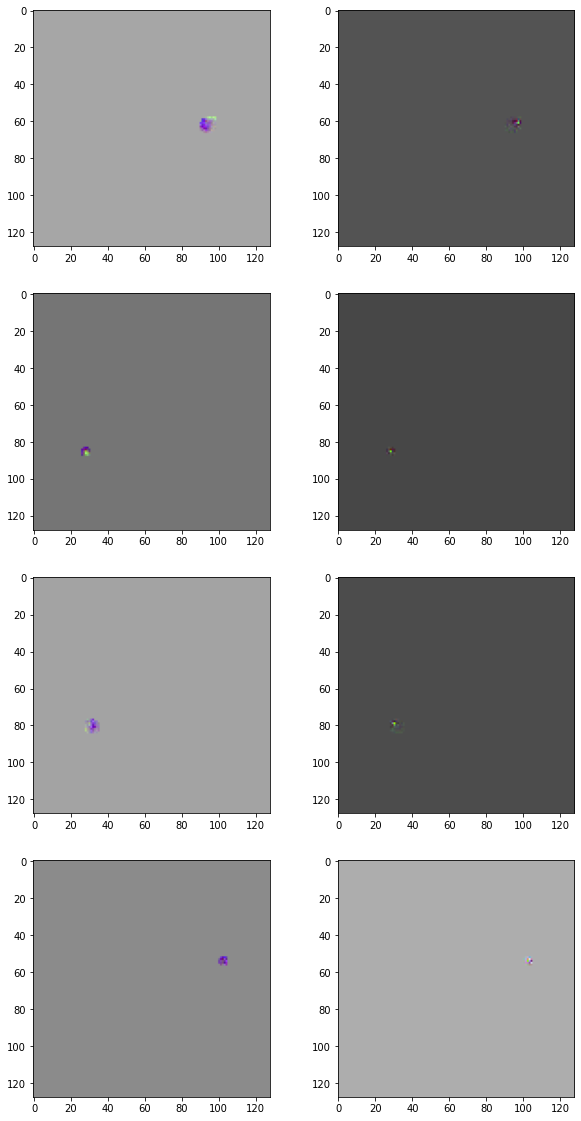

In [20]:
# generate classifier's derivative:
fig1 = plt.figure(figsize=(10, 20))
raw_length = len(intermediates["grad"])-1
for k in range(bs):
    for i in range(raw_length):
        ax = fig1.add_subplot(bs,raw_length,raw_length*k+i+1)
        grad = intermediates["grad"][i+1][k].permute(1,2,0)
        grad_norm = (grad - grad.min())/(grad.max() - grad.min())
        ax.imshow(grad_norm.cpu())

DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 3, 128, 128), eta 1.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


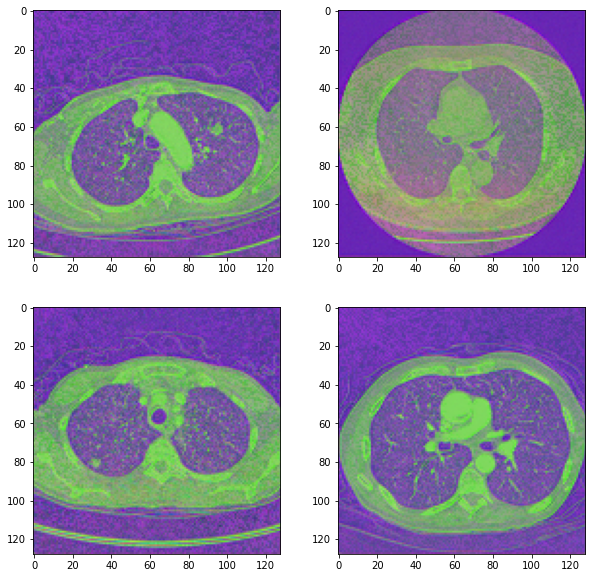

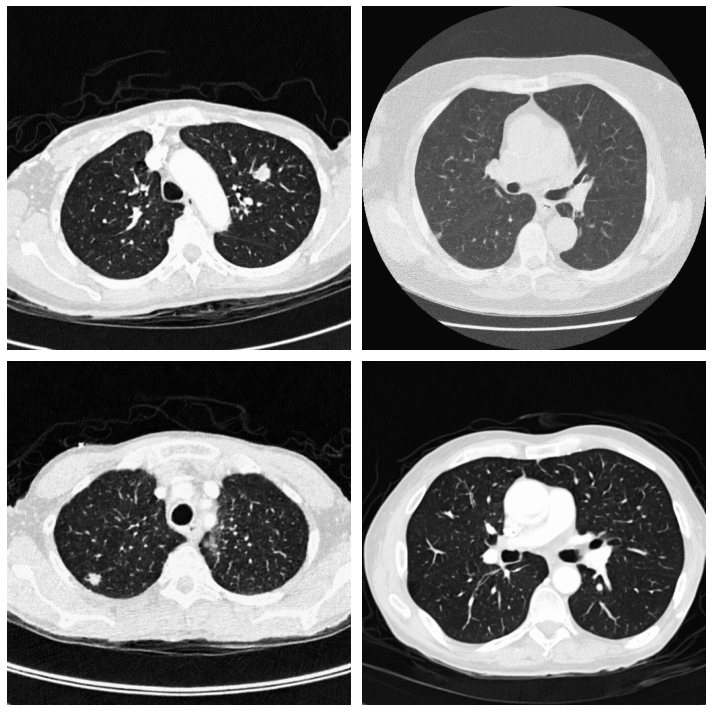

In [21]:
# STEP 1: generation:
"""
Parameters:
"""
sampling_steps = 20
class_label = 1  # {0,1}
guidance_scale = 1.

# generate latent:
samples_ddim, intermediates = sampler.sample_classifier_guidance(S=sampling_steps,
                                                                 conditioning=c_dict,
                                                                 class_label=class_label,
                                                                 batch_size=bs,
                                                                 shape=[3, 128, 128],
                                                                 verbose=False,
                                                                 unconditional_guidance_scale=3.0,
                                                                 eta=1.0,
                                                                 classifier_guidance_scale=guidance_scale,
                                                                 )
# normalize:
latent = (samples_ddim - torch.min(samples_ddim)) / (torch.max(samples_ddim) - torch.min(samples_ddim))
latent = torch.permute(latent, (0,2,3,1)).cpu().numpy()
latent = (latent * 255).astype(np.uint8)
fig1 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax1 = fig1.add_subplot(bs // 2,2,i+1)
    ax1.imshow(latent[i,:,:,:])

# generated images:
lsdm_model.eval()
x_samples_ddim = lsdm_model.decode_first_stage(samples_ddim)
generated = (x_samples_ddim - torch.min(x_samples_ddim)) / (torch.max(x_samples_ddim) - torch.min(x_samples_ddim))
generated = torch.permute(generated, (0,2,3,1)).cpu().numpy()
fig2 = plt.figure(figsize=(10, 10))
for i in range(bs):
    ax2 = fig2.add_subplot(bs//2,2,i+1)
    ax2.imshow(generated[i,:,:,:], cmap="gray")
    ax2.axis("off")
    plt.tight_layout()

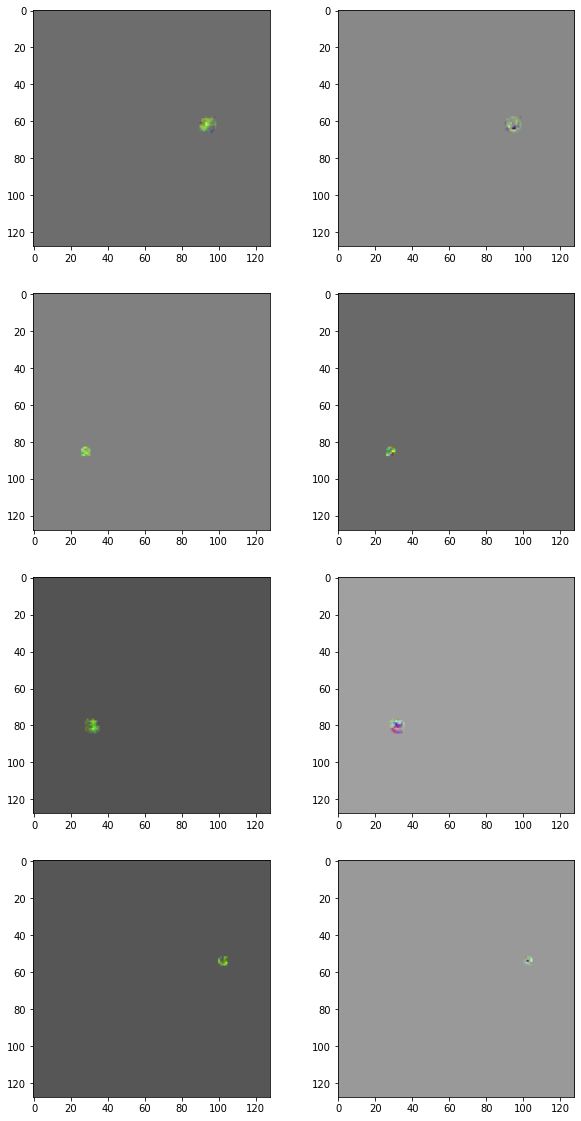

In [22]:
# generate classifier's derivative:
fig1 = plt.figure(figsize=(10, 20))
raw_length = len(intermediates["grad"])-1
for k in range(bs):
    for i in range(raw_length):
        ax = fig1.add_subplot(bs,raw_length,raw_length*k+i+1)
        grad = intermediates["grad"][i+1][k].permute(1,2,0)
        grad_norm = (grad - grad.min())/(grad.max() - grad.min())
        ax.imshow(grad_norm.cpu())